# 01 - Data Analysis and Preparation

This notebook covers the following tasks:

1. Perform exploratory data analysis and visualization.
2. Prepare the data for the ML task in BigQuery.
3. Generate and fix a ` TFDV schema` for the source data.
4. Create a `Vertex Dataset resource` dataset.


## Dataset

Credit Card Fraud https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Load the data:

```
$ bq load --skip_leading_rows=1 vertex_eu.creditcards creditcard.csv Time:STRING,V1:FLOAT,V2:FLOAT,V3:FLOAT,V4:FLOAT,V5:FLOAT,V6:FLOAT,V7:FLOAT,V8:FLOAT,V9:FLOAT,V10:FLOAT,V11:FLOAT,V12:FLOAT,V13:FLOAT,V14:FLOAT,V15:FLOAT,V16:FLOAT,V17:FLOAT,V18:FLOAT,V19:FLOAT,V20:FLOAT,V21:FLOAT,V22:FLOAT,V23:FLOAT,V24:FLOAT,V25:FLOAT,V26:FLOAT,V27:FLOAT,V28:FLOAT,Amount:FLOAT,Class:STRING
```

The ML task is to predict whether a given operation is fraudulent.

## Setup

### Import libraries

In [1]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow_data_validation as tfdv
from google.cloud import bigquery
import matplotlib.pyplot as plt

from google.cloud import aiplatform as vertex_ai

### Setup Google Cloud project

In [2]:
#PROJECT = 'cxb1-prj-test-no-vpcsc' 
PROJECT = 'pbalm-cxb-aa' 
REGION = 'europe-west4' 

if PROJECT == "" or PROJECT is None or PROJECT == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT = shell_output[0]
    
print("Project ID:", PROJECT)
print("Region:", REGION)

Project ID: pbalm-cxb-aa
Region: europe-west4


### Set configurations

In [3]:
BQ_SOURCE_TABLE= 'creditcards'
ML_TABLE = 'creditcards_ml'

BQ_DATASET_NAME = 'vertex_eu' # Change to your BQ dataset name.
BQ_LOCATION = 'EU'

VERTEX_DATASET_NAME = 'creditcards'

RAW_SCHEMA_DIR = 'src/raw_schema'

In [5]:
!yes | gcloud config set project {PROJECT}

Updated property [core/project].
yes: standard output: Broken pipe


## 1. Explore the data in BigQuery

In [6]:
from google.cloud import bigquery

client = bigquery.Client()  

sql = f"SELECT * FROM `{PROJECT}.{BQ_DATASET_NAME}.{BQ_SOURCE_TABLE}` LIMIT 10"
print(sql)

query_job = client.query(sql, location=BQ_LOCATION)
df = query_job.result().to_dataframe()

SELECT * FROM `pbalm-cxb-aa.vertex_eu.creditcards` LIMIT 10


In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,282,-0.356466,0.725418,1.971749,0.831343,0.369681,-0.107776,0.751610,-0.120166,-0.420675,...,0.020804,0.424312,-0.015989,0.466754,-0.809962,0.657334,-0.043150,-0.046401,0.0,0
1,380,-1.299837,0.881817,1.452842,-1.293698,-0.025105,-1.170103,0.861610,-0.193934,0.592001,...,-0.272563,-0.360853,0.223911,0.598930,-0.397705,0.637141,0.234872,0.021379,0.0,0
2,403,1.237413,0.512365,0.687746,1.693872,-0.236323,-0.650232,0.118066,-0.230545,-0.808523,...,-0.077543,-0.178220,0.038722,0.471218,0.289249,0.871803,-0.066884,0.012986,0.0,0
3,430,-1.860258,-0.629859,0.966570,0.844632,0.759983,-1.481173,-0.509681,0.540722,-0.733623,...,0.268028,0.125515,-0.225029,0.586664,-0.031598,0.570168,-0.043007,-0.223739,0.0,0
4,711,-0.431349,1.027694,2.670816,2.084787,-0.274567,0.286856,0.152110,0.200872,-0.596505,...,0.001241,0.154170,-0.141533,0.384610,-0.147132,-0.087100,0.101117,0.077944,0.0,0


In [8]:
%%bigquery data --project {PROJECT} --verbose

SELECT 
  Class, count(*) as n
FROM `vertex_eu.creditcards`
GROUP BY Class


Executing query with job ID: 078b8f0d-6e6e-4fb5-aaf7-ab79303d6e0d
Query executing: 0.27s
Query complete after 0.54s


Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.81rows/s]


In [9]:
data

,Class,n
0,0,284315
1,1,492


<AxesSubplot:xlabel='Class'>

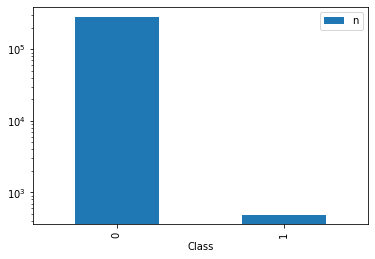

In [10]:
data.plot(kind='bar', x='Class', y='n', logy=True)

## 2. Create data for the ML task

We add a `ML_use` column for pre-splitting the data, where 80% of the datsa items are set to `UNASSIGNED` while the other 20% is set to `TEST`.

This column is used during training to split the dataset for training and test.

In the training phase, the `UNASSIGNED` are split into `train` and `eval`. The `TEST` split is will be used for the final model validation.

In [11]:
sql_script = f'''
CREATE OR REPLACE TABLE `{PROJECT}.{BQ_DATASET_NAME}.{ML_TABLE}` 
AS (
    SELECT
      * EXCEPT(Class),
      CAST(Class AS FLOAT64) as Class,
      IF(ABS(MOD(FARM_FINGERPRINT(Time), 100)) <= 80, 'UNASSIGNED', 'TEST') AS ML_use
    FROM
      `{PROJECT}.{BQ_DATASET_NAME}.{BQ_SOURCE_TABLE}`
)
'''

In [12]:
bq_client = bigquery.Client(project=PROJECT, location=BQ_LOCATION)
job = bq_client.query(sql_script)
job.result()

In [13]:
%%bigquery --project {PROJECT}

SELECT ML_use, Class, COUNT(*) as n
FROM vertex_eu.creditcards_ml
GROUP BY ML_use, Class

Downloading: 100%|██████████| 4/4 [00:01<00:00,  3.77rows/s]


,ML_use,Class,n
0,TEST,0.0,53405
1,TEST,1.0,90
2,UNASSIGNED,0.0,230910
3,UNASSIGNED,1.0,402


### Load a sample data to a Pandas DataFrame

In [14]:
%%bigquery sample_data --project {PROJECT}

SELECT * EXCEPT (Time, ML_use)
FROM vertex_eu.creditcards_ml limit 1000

Downloading: 100%|██████████| 1000/1000 [00:01<00:00, 872.54rows/s]


In [15]:
sample_data.head().T

,0,1,2,3,4
V1,1.047303,1.114352,1.309590,1.747061,1.930478
V2,0.080162,0.217501,-0.873058,0.372566,0.173452
V3,1.605951,1.525827,1.239225,0.262220,-0.237074
V4,2.941356,2.901716,-0.462648,3.857256,3.611991
V5,-0.806507,-0.714512,-1.713881,0.465517,0.213580
V6,0.669142,0.417171,-0.253322,1.596578,1.071615
V7,-0.688054,-0.525759,-1.335062,-0.663518,-0.659003
V8,0.329593,0.135248,0.213236,0.437938,0.328462
V9,0.454050,0.276007,0.104325,0.789845,-0.064064
V10,0.343653,0.348667,0.511733,0.874323,1.404958


In [16]:
sample_data.Class.value_counts()

0.0    995
1.0      5
Name: Class, dtype: int64

<AxesSubplot:>

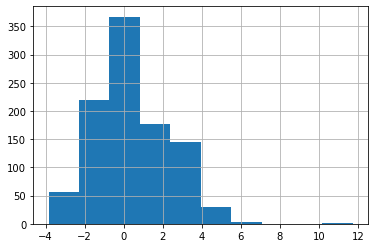

In [17]:
sample_data.V4.hist()

## 3. Generate raw data schema

The [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started) data schema will be used in:
1. Identify the raw data types and shapes in the data transformation.
2. Create the serving input signature for the custom model.
3. Validate the new raw training data in the TFX pipeline.

In [18]:
stats = tfdv.generate_statistics_from_dataframe(
    dataframe=sample_data,
    stats_options=tfdv.StatsOptions(
        label_feature='Class',
        weight_feature=None,
        sample_rate=1,
        num_top_values=50
    )
)

In [19]:
tfdv.visualize_statistics(stats)

In [20]:
schema = tfdv.infer_schema(statistics=stats)
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'V1',FLOAT,required,,-
'V2',FLOAT,required,,-
'V3',FLOAT,required,,-
'V4',FLOAT,required,,-
'V5',FLOAT,required,,-
'V6',FLOAT,required,,-
'V7',FLOAT,required,,-
'V8',FLOAT,required,,-
'V9',FLOAT,required,,-


In [21]:
raw_schema_location = os.path.join(RAW_SCHEMA_DIR, 'schema.pbtxt')
tfdv.write_schema_text(schema, raw_schema_location)

## 4. Create Vertex Dataset resource

In [8]:
print("Project ID:", PROJECT)
print("Region:", REGION)

vertex_ai.init(
    project=PROJECT,
    location=REGION
)

Project ID: pbalm-cxb-aa
Region: europe-west4


### Create the dataset resource

In [25]:
bq_uri = f"bq://{PROJECT}.{BQ_DATASET_NAME}.{ML_TABLE}"

dataset = vertex_ai.TabularDataset.create(
    display_name=VERTEX_DATASET_NAME, bq_source=bq_uri)

dataset.gca_resource

Creating TabularDataset
Create TabularDataset backing LRO: projects/188940921537/locations/europe-west4/datasets/5463301754605010944/operations/5300842864287154176
TabularDataset created. Resource name: projects/188940921537/locations/europe-west4/datasets/5463301754605010944
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/188940921537/locations/europe-west4/datasets/5463301754605010944')


name: "projects/188940921537/locations/europe-west4/datasets/5463301754605010944"
display_name: "creditcards"
metadata_schema_uri: "gs://google-cloud-aiplatform/schema/dataset/metadata/tabular_1.0.0.yaml"
create_time {
  seconds: 1655388212
  nanos: 956899000
}
update_time {
  seconds: 1655388220
  nanos: 16916000
}
etag: "AMEw9yNfT4MbtFognOHnv4pc2EzuwRJ9GMnlZNvVO4yIoRnAMkH-rEEWSztrm1d7xI4="
labels {
  key: "aiplatform.googleapis.com/dataset_metadata_schema"
  value: "TABLE"
}
metadata {
  struct_value {
    fields {
      key: "inputConfig"
      value {
        struct_value {
          fields {
            key: "bigquerySource"
            value {
              struct_value {
                fields {
                  key: "uri"
                  value {
                    string_value: "bq://pbalm-cxb-aa.vertex_eu.creditcards_ml"
                  }
                }
              }
            }
          }
        }
      }
    }
  }
}

### Get the dataset resource

The dataset resource is retrieved by display name. Because multiple datasets can have the same display name, we retrieve the most recent updated one.

In [9]:
dataset = vertex_ai.TabularDataset.list(
    filter=f"display_name={VERTEX_DATASET_NAME}", 
    order_by="update_time")[-1]

print("Dataset resource name:", dataset.resource_name)
print("Dataset BigQuery source:", dataset.gca_resource.metadata['inputConfig']['bigquerySource']['uri'])

Dataset resource name: projects/188940921537/locations/europe-west4/datasets/5463301754605010944
Dataset BigQuery source: bq://pbalm-cxb-aa.vertex_eu.creditcards_ml
